## **Building a Deep Neural Network for Image Classification with MNIST Dataset**

#### Welcome to Exploring Neural Networks for Digit Recognition

In this notebook, we will build a deep neural network from scratch using Python and NumPy to perform image classification tasks on the MNIST dataset. 

The two purposes of this notebook are:

1. Detailed Analysis: Provide an in-depth analysis of designing and implementing a neural network, including training processes and optimization techniques.

2. Optimization Techniques: Explore the theory behind Mini-Batch Gradient Descent and the advanced Adam Optimizer for model optimization.

### **Introduction**

The MNIST dataset is a popular benchmark in the field of machine learning, consisting of handwritten digit images. Our objective is to develop a DNN capable of accurately recognizing and classifying these digit images.

Also, this notebook will cover various useful methodologies, such as:
- Evaluating a DNN with 2 hidden layers and an output layer including 9 neurons (since the digits range from 0-9).
- Learning Rate Decay.
- Implementing advanced optimization techniques, such as Adam optimizer + Mini-Batch Gradient Descent.
- Using regularization techniques, such as L2-norm to improve model performance and prevent overfitting.

### Task 1a. Imports and loading

We begin by loading the MNIST dataset from a CSV file using the Pandas library. The dataset contains pixel values of grayscale images along with corresponding labels. After loading the data, we perform the following preprocessing steps:

- Rename the label column to 'label' for clarity.

- Convert the dataset into a NumPy array and transpose it for easier manipulation.

- Separate the labels **(`target`)** from the features **(`features`)**.

- Normalize the pixel values of the images by scaling them to a range between 0 and 1.

First, let's begin by importing essential libraries and loading the data.

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the MNIST dataset
data = pd.read_csv('mnist_train_small.csv')
data = data.rename(columns={'6':'label'}) # Rename the label column for clarity

# Display a few couple of rows
data.head()

,label,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Task 2a. Data Preprocessing

This task will follow in general the following steps:
1. Data Preprocessing
2. Data Transpose 
3. Splitting the Data into features (input) and labels (output) for further analysis.
4. and finally, Data Normalization

In [3]:
# Convert data to NumPy array and transpose for easier manipulation
data = np.array(data)
data = data.T

In [4]:
# Extract the target from the whole dataset
label = data[0]

# Produce a 2x2 One-Hot Encoded matrix
number_classes = len(np.unique(data[0]))
target = np.eye(number_classes)[label]

# Transpose the target and display it
target = target.T

In [5]:
# Normalize features by the Maximum Factor
features = data[1:]
features = np.divide(features, 255.0)

In [6]:
# Print the shape of both sets
print(f"Shape of Features: {features.shape}")
print(f"Shape of Target: {target.shape}")

Shape of Features: (784, 19999)
Shape of Target: (10, 19999)


### Task 3a. Split data into training, and validation sets

To efficiently train our neural network, we implement a function to generate random mini-batches of data. This technique is essential when working with large datasets, as it enables us to perform mini-batch gradient descent much faster during the training process. By randomly selecting smaller subsets of the data, we are able to optimize the performance of the neural network and minimize training time.

In [7]:
def random_mini_batches(X, Y, validation_split=0.2, mini_batch_size=32, seed=0):

    np.random.seed(seed)  # Set seed for reproducibility
    m = X.shape[1]  # Total number of examples
    m_val = int(m * validation_split)  # Number of validation examples

    # Shuffle indices
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Split into training and validation sets
    X_train = shuffled_X[:, m_val:]
    Y_train = shuffled_Y[:, m_val:]
    X_val = shuffled_X[:, :m_val]
    Y_val = shuffled_Y[:, :m_val]

    # Generate random mini-batches for training data
    num_complete_minibatches_train = X_train.shape[1] // mini_batch_size
    mini_batches_train = []

    for k in range(num_complete_minibatches_train):
        mini_batch_X_train = X_train[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y_train = Y_train[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batches_train.append((mini_batch_X_train, mini_batch_Y_train))

    # Handling the end case (last mini-batch < mini_batch_size) for training
    if X_train.shape[1] % mini_batch_size != 0:
        mini_batch_X_train = X_train[:, num_complete_minibatches_train * mini_batch_size :]
        mini_batch_Y_train = Y_train[:, num_complete_minibatches_train * mini_batch_size :]
        mini_batches_train.append((mini_batch_X_train, mini_batch_Y_train))

    # Generate random mini-batches for validation data
    num_complete_minibatches_val = X_val.shape[1] // mini_batch_size
    mini_batches_val = []

    for k in range(num_complete_minibatches_val):
        mini_batch_X_val = X_val[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y_val = Y_val[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batches_val.append((mini_batch_X_val, mini_batch_Y_val))

    # Handling the end case (last mini-batch < mini_batch_size) for validation
    if X_val.shape[1] % mini_batch_size != 0:
        mini_batch_X_val = X_val[:, num_complete_minibatches_val * mini_batch_size :]
        mini_batch_Y_val = Y_val[:, num_complete_minibatches_val * mini_batch_size :]
        mini_batches_val.append((mini_batch_X_val, mini_batch_Y_val))

    return mini_batches_train, mini_batches_val

mini_batches_train, mini_batches_val = random_mini_batches(features, target, validation_split=0.2, mini_batch_size=32, seed=0)

print(f"Shape of train batches: {len(mini_batches_train)}")
print(f"Shape of validation batches: {len(mini_batches_val)}")

Shape of train batches: 500
Shape of validation batches: 125


### Task 1b. Activation Functions

In neural networks, we use various activation functions in each hidden layer to introduce non-linearity, which allows the model to capture complex patterns. The activation functions used in this notebook will be:

- **`Swish`**
- **`Leaky ReLU`**
- **`Softmax`**

In [8]:
# Sigmoid activation function (essential for Swish activation function)
def Sigmoid(z):
    return 1 / (1 + (np.exp(-z)))


# Swish activation function: Combines sigmoid with input 'z' multiplied by a scaling factor 'gamma'
def Swish(z, gamma=1):
    return z * Sigmoid(z * gamma)


# Derivative of Swish activation function
def Swish_derivative(z, gamma=1):
    return Sigmoid(z * gamma) + z * (1 - Sigmoid(z * gamma))


# Leaky ReLU activation function: Introduces a small negative slope ('alpha') for negative inputs
def Leaky_ReLU(z, alpha=0.01):
    return np.maximum(z, z * alpha)


# Derivative of Leaky ReLU activation function
def Leaky_ReLU_derivative(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)


# Softmax activation function: Computes probabilities for multiple classes using 'z' values
def Softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Avoid Overflow
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

### Task 2b. Parameter Initialization

The neural network's parameters (weights and biases) are initialized before training begins. This process of initialization involves setting random starting values for the parameters, which are then adjusted during training in order to improve the network's performance.

Weights are going to be set to a small random number, whereas biases are set as zeros.

The reason behind multiplying weights by a small constant is to ensure that the weights of the function are not only randomized but also relatively small in order not to affect the training process.

By setting biases as zeros, we are able to eliminate any potential bias that may be introduced into the model.

In [9]:
def initialize_parameters(input_size, first_hidden_size, second_hidden_size, output_size):

    W1 = np.random.randn(first_hidden_size, input_size) * 0.01  # Multiply by a small factor
    b1 = np.zeros((first_hidden_size, 1))

    W2 = np.random.randn(second_hidden_size, first_hidden_size) * 0.01
    b2 = np.zeros((second_hidden_size, 1))

    W3 = np.random.randn(output_size, second_hidden_size) * 0.01
    b3 = np.zeros((output_size, 1))

    parameters = {'W1':W1,
                  'b1':b1,
                  'W2':W2,
                  'b2':b2,
                  'W3':W3,
                  'b3':b3}

    return parameters

### Task 3b. Feed Forward Neural Network

During forward propagation, input data is passed through the network layers, and activations are computed using the initialized parameters and activation functions.

In [10]:
def forward_propagation(X, parameters):

    # Get weights and biases from parameters dictionary
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
    W3, b3 = parameters['W3'], parameters['b3']

    # Perform linear transformations and activation functions
    z1 = np.dot(W1, X) + b1
    a1 = Swish(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = Leaky_ReLU(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = Softmax(z3)

    forward_cache = {'z1':z1,
                     'a1':a1,
                     'z2':z2,
                     'a2':a2,
                     'z3':z3,
                     'a3':a3}

    return a3, forward_cache

### Task 4b. Regularized Cost Function

Cost function quantifies the disparity between predicted outputs and ground truth labels, and serves as a metric to evaluate the model's performance.
For the purpose of `Backpropagation`, we need to first derive from this equation.

Note that we are using a regularization term "L2-norm"; so we need to mention that out in our cost formula as well.

$Cost = - \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{n}[ y_k \log(a_k) ] + \frac{\lambda}{2m} \sum_{j=1}^{p} w_j^2$

In [11]:
def compute_cost(a3, y, parameters, penalty, epsilon=1e-8):

    # Get the model parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    # Number of examples in the dataset
    n = y.shape[1]

    # Compute log probabilities
    logprobs = np.multiply(-np.log(a3 + epsilon), y)
    cost = np.mean(logprobs)

    # Compute regularization term
    regularized_cost = np.divide(penalty, np.multiply(2, n)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    total_cost = cost + regularized_cost

    return total_cost

### Task 1c. Backpropagation

During the training of a neural network, the backpropagation algorithm is used to calculate the gradients of the loss function with respect to each parameter in the network. These gradients are then used to update the parameters in the network, which ultimately leads to an improvement in the network's ability to make accurate predictions. The backpropagation algorithm works by computing the derivatives of the loss function with respect to each weight in the network, and then propagating these derivatives backwards through the network to update the weights. This process is repeated many times during training, gradually improving the network's performance until it reaches a satisfactory level.

In [12]:
def backpropagation(X, y, parameters, forward_cache, penalty):

    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    z1 = forward_cache['z1']
    a1 = forward_cache['a1']
    z2 = forward_cache['z2']
    a2 = forward_cache['a2']
    a3 = forward_cache['a3']

    m = X.shape[1]  # Number of training examples

    # gradients for output layer
    dZ3 = a3 - y
    dW3 = np.dot(dZ3, a2.T) / m + np.multiply(np.divide(penalty, m), W3)
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m

    # gradients for second hidden layer
    dZ2 = np.dot(W3.T, dZ3) * Leaky_ReLU_derivative(z2)
    dW2 = np.dot(dZ2, a1.T) / m + np.multiply(np.divide(penalty, m), W2)
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    # gradients for first hidden layer
    dZ1 = np.dot(W2.T, dZ2) * Swish_derivative(z1)
    dW1 = np.dot(dZ1, X.T) / m + np.multiply(np.divide(penalty, m), W1)
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    gradients = {'dW1':dW1,
               'db1':db1,
               'dW2':dW2,
               'db2':db2,
               'dW3':dW3,
               'db3':db3}

    return gradients

### Task 2c. Adam Optimization**

Our network uses `Adam` as the optimizer, which is indeed much faster than the traditional SGD + Momentum.

The Adam algorithm uses adaptive learning rates to update network parameters efficiently, which allows it to converge faster than other optimization algorithms.

In [13]:
def initialize_adam(parameters):

    # Define two empty dictionaries for `Momentum`, and `RMSprop`, respectively
    velocity = {}
    cache = {}

    # Initialize velocity and cache with zeros of the same shape as the parameter
    for key, value in parameters.items():
        velocity[key] = np.zeros_like(value)
        cache[key] = np.zeros_like(value)

    return velocity, cache

### Task 3c. Updating parameters with Adam

Adam is considered one of the most effective and capable optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum to improve performance.

The algorithm applies individual learning rates to each parameter and adapts the updates based on the accumulated past gradients and squared gradients.

In addition, bias-correction term is considered into the algorithm to prevent the optimization process from becoming trapped in local minima.

alongside Adam Optimizer and Mini-Batch Gradient Descent, we will use another commonly used technique called `Learning Rate Decay`. This is the process of gradually reducing the learning rate at each step. It prevents the model, not to overshoot the optima.

In [14]:
def update_parameters(parameters, gradients, velocity, cache, learning_rate, decay_rate, current_iteration, momentum_coefficient=0.9, rmsprop_coefficient=0.999, epsilon=1e-8):

    # beta1 and beta2 based on specified coefficients
    beta1 = momentum_coefficient
    beta2 = rmsprop_coefficient

    corrected_velocity = {}
    corrected_cache = {}

    # Compute decayed learning rate
    learning_rate_decay = learning_rate / (1 + decay_rate * current_iteration)

    # Update velocity with momentum term and cache with RMSprop term
    for parameter in parameters:

        velocity[parameter] = beta1 * velocity[parameter] + (1 - beta1) * gradients['d' + parameter]
        corrected_velocity[parameter] = velocity[parameter] / (1 - beta1)

        cache[parameter] = beta2 * cache[parameter] + (1 - beta2) * (gradients['d' + parameter] ** 2)
        corrected_cache[parameter] = cache[parameter] / (1 - beta2)

        parameters[parameter] -= learning_rate_decay * corrected_velocity[parameter] / (np.sqrt(corrected_cache[parameter]) + epsilon)

    return parameters, velocity, cache

### Task 1d. Predictions and Evaluation Metrics

We would consider `Accuracy` as the Evaluation Metrics.

To calculate accuracy, first, make predictions on the validation-test data, and then, use the corresponding ground truth to calculate the proportion of true predicted images by the model.

In [15]:
def predict(x, parameters):
    a3, _ = forward_propagation(x, parameters)
    return np.argmax(a3, axis=0)  # Get the prediction with the highest probability

In [16]:
def accuracy_score(prediction, label):

    # Calculate the proportion of corrected labels
    return np.mean(prediction == np.argmax(label, axis=0))

### Task 2d. Plotting the Training / Validation Cost Function**

Within the following function, we will generate a visual representation of the performance of the Cost Function. This will include both the Training and Validation phases.

In [17]:
def plot_cost_graph(train_cost_history, val_cost_history):

    # Plot the cost in each iteration (loss)
    sns.set_theme(style='darkgrid')
    train_iterations = len(train_cost_history)
    val_iterations = len(val_cost_history)
    plt.figure(figsize=(15, 6))
    plt.plot(range(train_iterations), train_cost_history, label='Training Cost', color='blue')
    plt.plot(range(val_iterations), val_cost_history, label='Validation Cost', color='red')
    plt.title('Cost vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.legend()
    plt.show();

### Task 1e. Evaluating the Network

The DNN is trained using mini-batch gradient descent with Adam optimization. Training involves iterating over the dataset for a specified number of epochs, computing forward and backward passes, and updating network parameters.

In [18]:
def mini_batch_gradient_descent(X_train, Y_train, input_size, first_hidden_size, second_hidden_size, output_size, penalty, learning_rate, iterations, mini_batch_size=32, decay_rate=0.1):
    
    parameters = initialize_parameters(input_size, first_hidden_size, second_hidden_size, output_size)
    velocity, cache = initialize_adam(parameters)

    # Store the cost of both sets
    train_cost_history = []
    val_cost_history = []

    for epoch in range(iterations):
        epoch_cost = 0  # Initialize the cost for both Training / validation sets
        val_epoch_cost = 0
        seed = epoch  # Set seed for reproducibility of mini-batches

        mini_batches_train, _ = random_mini_batches(X_train, Y_train, mini_batch_size=mini_batch_size, seed=seed)

        for mini_batch_X, mini_batch_Y in mini_batches_train:
            
            # Compute Forwardpropagation
            a3, forward_cache = forward_propagation(mini_batch_X, parameters)

            # Compute Training Cost
            cost = compute_cost(a3, mini_batch_Y, parameters, penalty)
            epoch_cost += cost

            # Backpropagation
            gradients = backpropagation(mini_batch_X, mini_batch_Y, parameters, forward_cache, penalty)

            # Updating
            parameters, velocity, cache = update_parameters(parameters, gradients, velocity, cache, learning_rate, decay_rate, epoch)

        epoch_cost /= len(mini_batches_train)
        train_cost_history.append(epoch_cost)

        # Validation
        for mini_batch_X_val, mini_batch_Y_val in mini_batches_val:
            a3_val, forward_cache = forward_propagation(mini_batch_X_val, parameters)

            val_cost = compute_cost(a3_val, mini_batch_Y_val, parameters, penalty)
            val_epoch_cost += val_cost

        val_epoch_cost /= len(mini_batches_val)
        val_cost_history.append(val_epoch_cost)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Cost = {epoch_cost:.4}, Validation Cost = {val_epoch_cost:.4}")

    return parameters, train_cost_history, val_cost_history

input_size = features.shape[0]
first_hidden_size = 64
second_hidden_size = 32
output_size = number_classes  # Number of classes

penalty = 0.001
learning_rate = 0.0001
num_epochs = 200
mini_batch_size = 32
decay_rate = 0.001

Epoch 0: Train Cost = 0.1986, Validation Cost = 0.1554
Epoch 10: Train Cost = 0.06618, Validation Cost = 0.06583
Epoch 20: Train Cost = 0.05563, Validation Cost = 0.05585
Epoch 30: Train Cost = 0.04864, Validation Cost = 0.04932
Epoch 40: Train Cost = 0.04326, Validation Cost = 0.04427
Epoch 50: Train Cost = 0.03896, Validation Cost = 0.04021
Epoch 60: Train Cost = 0.03663, Validation Cost = 0.03715
Epoch 70: Train Cost = 0.03345, Validation Cost = 0.03479
Epoch 80: Train Cost = 0.03258, Validation Cost = 0.03306
Epoch 90: Train Cost = 0.03058, Validation Cost = 0.03174
Epoch 100: Train Cost = 0.02979, Validation Cost = 0.03068
Epoch 110: Train Cost = 0.02848, Validation Cost = 0.02979
Epoch 120: Train Cost = 0.02785, Validation Cost = 0.02902
Epoch 130: Train Cost = 0.02697, Validation Cost = 0.0282
Epoch 140: Train Cost = 0.02624, Validation Cost = 0.02772
Epoch 150: Train Cost = 0.02569, Validation Cost = 0.02706
Epoch 160: Train Cost = 0.02559, Validation Cost = 0.02656
Epoch 170: 

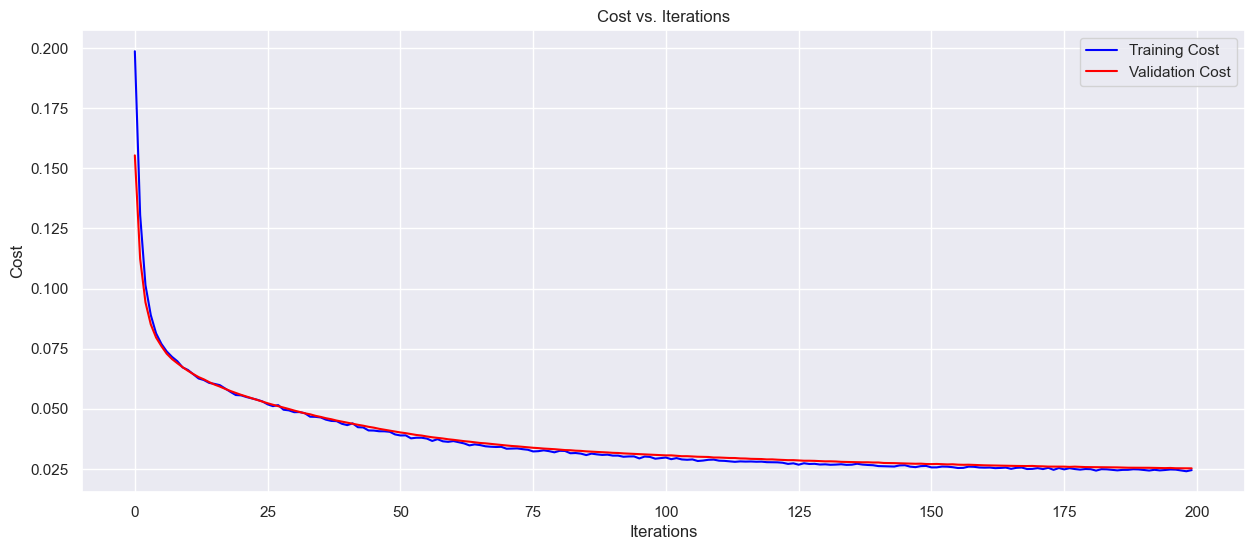

Training accuracy: 0.9538
Validation accuracy: 0.9525


In [19]:
# Perform gradient descent
trained_parameters, train_cost_history, val_cost_history = mini_batch_gradient_descent(features, target, input_size, first_hidden_size, second_hidden_size, output_size, penalty, learning_rate, num_epochs, mini_batch_size, decay_rate)

# Plot cost history
plot_cost_graph(train_cost_history, val_cost_history)

# Make predictions and evaluate accuracy
predictions_train = predict(features, trained_parameters)
accuracy_train = accuracy_score(predictions_train, target)
print(f"Training accuracy: {accuracy_train:.4}")

# Extract x and y components from each mini-batch in validation set
X_val_list = []
y_val_list = []
for mini_batch_X, mini_batch_Y in mini_batches_val:
    X_val_list.append(mini_batch_X)
    y_val_list.append(mini_batch_Y)

# Concatenate the extracted lists into single arrays
X_val = np.concatenate(X_val_list, axis=1)
y_val = np.concatenate(y_val_list, axis=1)

# Make predictions on the combined validation set
predictions_val = predict(X_val, trained_parameters)

# Calculate accuracy on the validation set
accuracy_val = accuracy_score(predictions_val, y_val)
print(f"Validation accuracy: {accuracy_val:.4}")

#### **Evaluation and Visualization**

After training, we evaluate the model's performance on both training and validation datasets by computing accuracy scores and visualizing training/validation costs over epochs.

In [20]:
def get_predictions(A3):
    return np.argmax(A3, 0)

def make_predictions(X, parameters):
    A3, _ = forward_propagation(X, parameters)
    predictions = get_predictions(A3)
    return predictions

def validation_prediction(index, parameters):
    sns.set_theme(style='dark')
    current_image = X_val[:, index, None]
    prediction = make_predictions(X_val[:, index, None], parameters)
    label_index = np.argmax(y_val[:, index])  # Find index of the maximum value in the one-hot encoded label
    label = label_index  # Assign the numerical label

    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show();

Prediction:  [1]
Label:  1


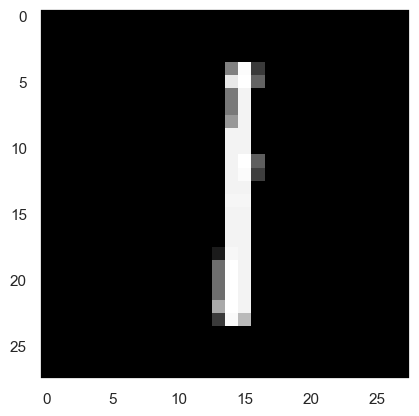

Prediction:  [9]
Label:  9


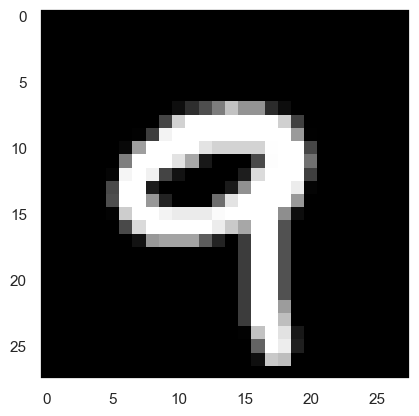

Prediction:  [8]
Label:  8


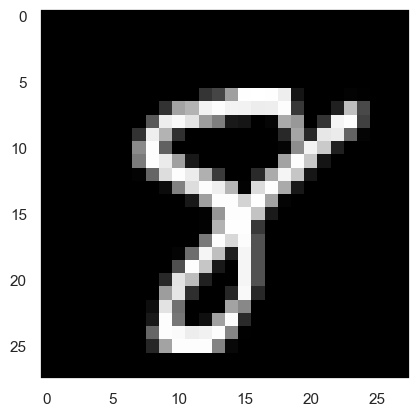

Prediction:  [4]
Label:  4


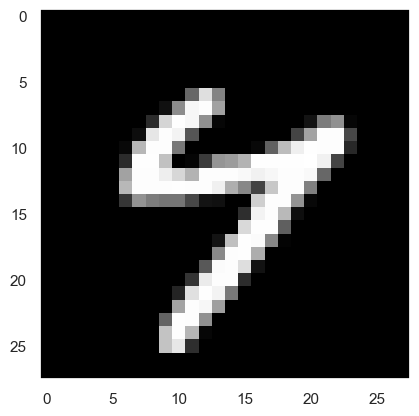

In [21]:
# Call the function
validation_prediction(120, trained_parameters)
validation_prediction(481, trained_parameters)
validation_prediction(62, trained_parameters)
validation_prediction(83, trained_parameters)

#### **Visualizing Wrong Predictions on Validation data**

Let us create a visual representation of the incorrect forecasts. It is essential to note that this visualization will aid in the identification of areas that require improvement and help us to adjust our forecasting models accordingly.

In [22]:
# How many Wrong predictions are estimated by our model?
print(f"The Number of Wrong Predictions: {len(predictions_val != y_val)}")

The Number of Wrong Predictions: 10


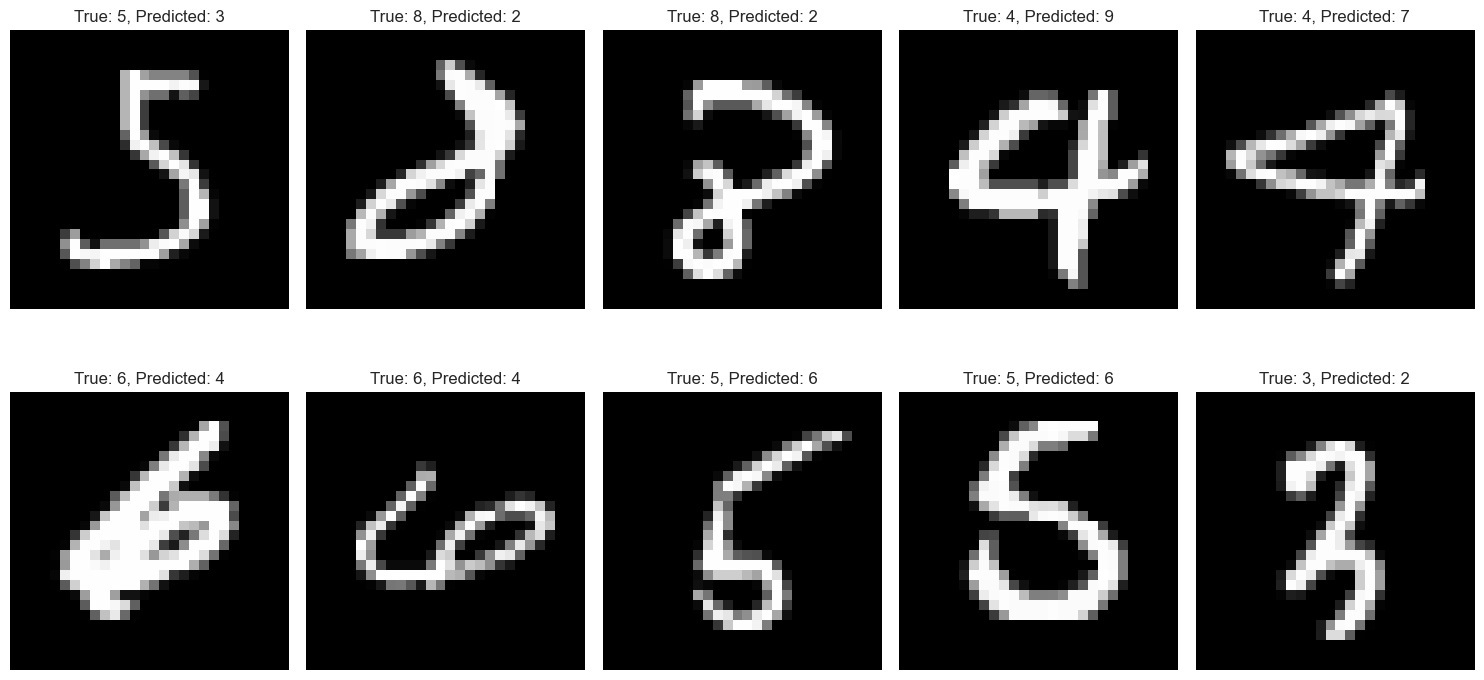

In [23]:
# Identify indices of incorrect predictions
incorrect_indices = np.where(predictions_val != np.argmax(y_val, axis=0))[0]

# Select first 10 incorrect indices (assuming there are at least 10 incorrect predictions)
incorrect_indices = incorrect_indices[:10]

# Plot the incorrect images alongside their correct labels
plt.figure(figsize=(15, 8))

for i, idx in enumerate(incorrect_indices):
    
    # Get the incorrectly predicted image and its true label
    incorrect_image = X_val[:, idx].reshape((28, 28)) * 255
    true_label = np.argmax(y_val[:, idx])

    # Make prediction for the image
    predicted_label = predictions_val[idx]

    # Plot the incorrect image with its predicted and true labels
    plt.subplot(2, 5, i + 1)
    plt.imshow(incorrect_image, cmap='gray')
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show();

#### **Loading and Preprocessing Test set**

Given the satisfactory performance of the model on the validation data, it can be deemed reliable for making predictions on the entire set of test data.

In a similar manner as we handled our training-validation set, our next step is to load and pre-process our test set.

In [24]:
# Load the Test data
test_data = pd.read_csv('mnist_test.csv')

In [25]:
# Preprocess the Test data similar to Train data
test_data = np.array(test_data)
test_data = test_data.T

In [26]:
# Extract the target and One-Hot Encode that
y_test = test_data[0]

number_classes = len(np.unique(test_data[0]))
y_test = np.eye(number_classes)[y_test]
y_test = y_test.T

In [27]:
# Extract and Scale the Pixels for the Test set
x_test = test_data[1:]
x_test = np.divide(x_test, 255.0)

#### **Making / Visualizing Predictions on Test data**

When it comes to evaluating the performance of machine learning models, making predictions on test data is a crucial step. Test data refers to a subset of data that is held out from the model during training, and is used to assess the model's ability to generalize to new, unseen data. By making predictions on the test data, we can measure the accuracy and effectiveness of the model and ensure that it performs well on data it has not seen before.

In [28]:
def get_predictions(A3):
    return np.argmax(A3, 0)

def make_predictions(X, parameters):
    A3, _ = forward_propagation(X, parameters)
    predictions = get_predictions(A3)
    return predictions

def test_prediction(index, parameters):
    sns.set_theme(style='dark')
    current_image = x_test[:, index, None]
    prediction = make_predictions(x_test[:, index, None], parameters)
    label_index = np.argmax(y_test[:, index])  # Find index of the maximum value in the one-hot encoded label
    label = label_index  # Assign the numerical label

    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show();

Prediction:  [5]
Label:  5


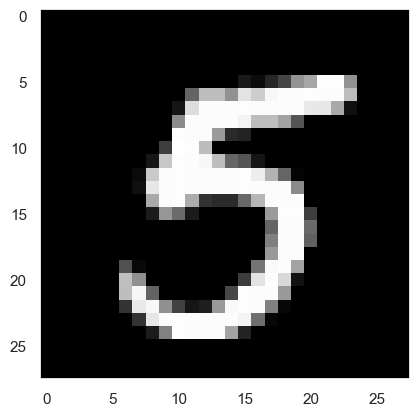

Prediction:  [7]
Label:  7


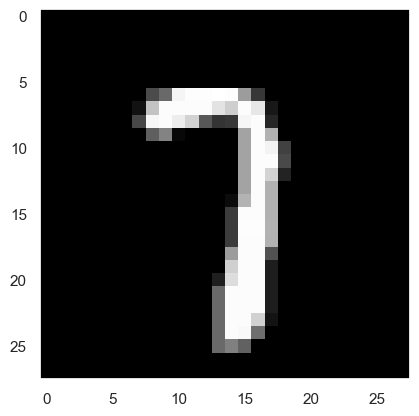

Prediction:  [4]
Label:  4


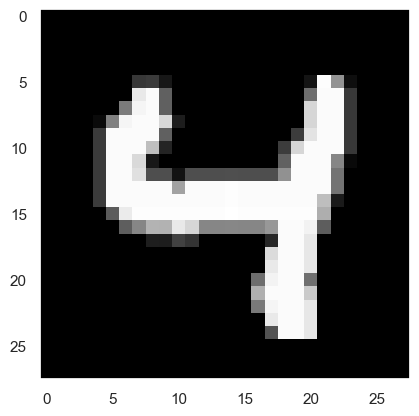

Prediction:  [8]
Label:  8


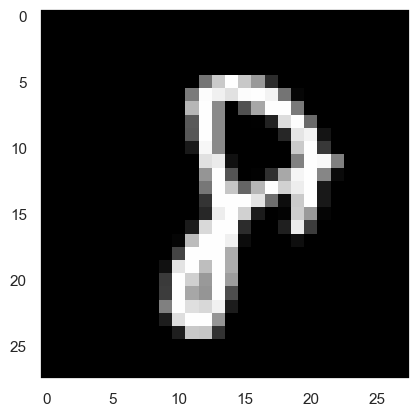

In [29]:
# Call the function
test_prediction(355, trained_parameters)
test_prediction(254, trained_parameters)
test_prediction(718, trained_parameters)
test_prediction(600, trained_parameters)

#### **Visualizing Wrong Predictions on Test data**

One way to gain insights into the performance of a machine learning model is to visualize its wrong predictions on test data. This involves creating visualizations that highlight instances where the model made incorrect predictions, which can help identify patterns and areas of improvement.

We'll tally up the incorrect forecasts and display them visually.

In [30]:
def predict(x_test, trained_parameters):
    a3, _ = forward_propagation(x_test, trained_parameters)
    return np.argmax(a3, axis=0)

predictions = predict(x_test, trained_parameters)

In [31]:
# Number of wrong predictions
print(f"The Number of Wrong Predictions: {len(predictions != y_test)}")

The Number of Wrong Predictions: 10


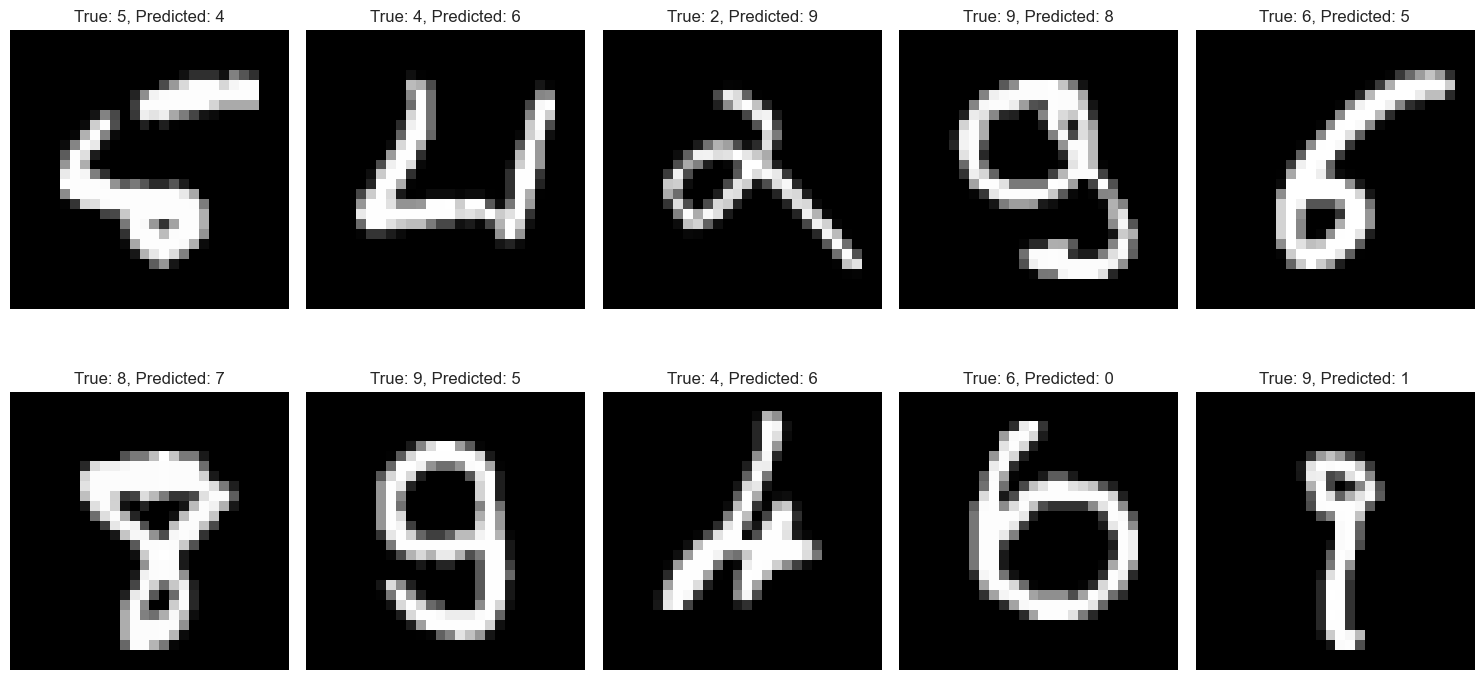

In [32]:
# Identify indices of incorrect predictions
incorrect_indices = np.where(predictions != np.argmax(y_test, axis=0))[0]

# Select first 10 incorrect indices (assuming there are at least 10 incorrect predictions)
incorrect_indices = incorrect_indices[:10]

# Plot the incorrect images alongside their correct labels
plt.figure(figsize=(15, 8))
for i, idx in enumerate(incorrect_indices):
    # Get the incorrectly predicted image and its true label
    incorrect_image = x_test[:, idx].reshape((28, 28)) * 255
    true_label = np.argmax(y_test[:, idx])

    # Make prediction for the image
    predicted_label = predictions[idx]

    # Plot the incorrect image with its predicted and true labels
    plt.subplot(2, 5, i + 1)
    plt.imshow(incorrect_image, cmap='gray')
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show();

#### **Accuracy score on Test data**

Let's calculate accuracy score. This score is an important metric that reflects the ability of the model to make correct predictions on previously unseen data.

In [33]:
# Accuracy score on Test data
def predict(x_test, trained_parameters):
    a3, _ = forward_propagation(x_test, trained_parameters)
    return np.argmax(a3, axis=0)

def accuracy_score(predictions, target):
    return np.mean(predictions == np.argmax(target, axis=0))

predictions = predict(x_test, trained_parameters)
print(f"Accuracy on Test set: {accuracy_score(predictions, y_test):.4}")

Accuracy on Test set: 0.9401


### **Conclusion**

*Model Performance Reports:*

> `Training` / `Validation` Accuracy: The high training and validation accuracies (above 95%) suggest that the model has learned meaningful patterns from the data and is performing well across different subsets of the dataset.

> `Test Set Accuracy:` The slightly lower test set accuracy (94.01%) indicates that the model's performance might degrade slightly on completely new, unseen data compared to the validation set. This could be due to inherent variability or differences between the test set and the training/validation sets.


Overall, a consistent accuracy across training, validation, and test sets 
indicates a robust model that generalizes well and is likely to perform reliably in practical applications.